# Tutorial on fitting single dataset using Inverse Solver
In addition to using a parametric model or a control-points approach, we can also infer the production rates and its uncertainties using an inverse solver.

In [1]:
import numpy as np
import ticktack
from ticktack import fitting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-colorblind')

In [2]:
sf = fitting.SingleFitter('Guttler15', 'Guttler15')
sf.load_data('miyake12.csv')
sf.compile_production_model("inverse_solver")

INFO[2022-03-16 12:42:32,800]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-16 12:42:32,801]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-16 12:42:32,802]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-16 12:42:32,803]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Let's infer production rates from Monte Carlo samples of the d14c data in `miyake12.csv` using an inverse solver, 

In [3]:
chain = sf.MC_reconstruct(iters=1000)
print("a sample from chain: \n", chain[0])
print("chain shape: ", chain.shape)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 142.97it/s]

a sample from chain: 
 [ 1.96002681  1.4480439   3.47545111 -2.50568993  6.40695506 -1.57191127
  4.99387901  2.02347553 -1.00583776  2.25123963  4.42994445 -1.47318762
  2.96294169  3.142116   -1.57489275 11.62382394  1.57461221 -0.380292
  3.19276808  2.82134977  0.03127797  3.39093834  2.53404239  3.12229718
 -0.27019036  5.14502456 -2.11314701  2.80210269]
chain shape:  (1000, 28)


Visualise the mean and the standard deviation of the chain, 

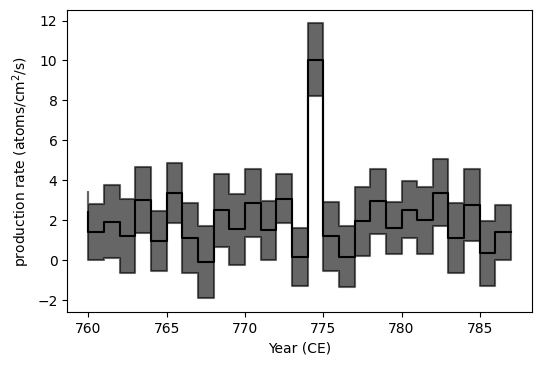

In [4]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
mean = np.mean(chain, axis=0)
std = np.std(chain, axis=0)
ax.errorbar(sf.time_data, mean, color='k', drawstyle="steps")
ax.fill_between(sf.time_data, mean - std, mean + std,
                step='pre', alpha=0.6, facecolor=(0, 0, 0, .1),
                edgecolor=(0, 0, 0, 0.8), lw=1.5)
ax.set_xlabel("Year (CE)")
ax.set_ylabel("production rate (atoms/cm$^2$/s)");

Unlike our other approaches, we cannot directly call `sf.dc14` on the inverse solver since this production rate model does not require burn-in. The reconstruction function below addresses this issue, but it is only appropriate for inverse solver,

In [5]:
def d14c(params):
    event = sf.run_event(y0=sf.steady_state_y0, params=(params,))
    binned_d14c = sf.cbm.bin_data(event[:, sf.box_idx], sf.oversample, sf.annual, growth=sf.growth)
    return (binned_d14c - 
            sf.steady_state_y0[sf.box_idx]) / sf.steady_state_y0[sf.box_idx] * 1000 + sf.d14c_data[0]

Visualise the reconstruction, 

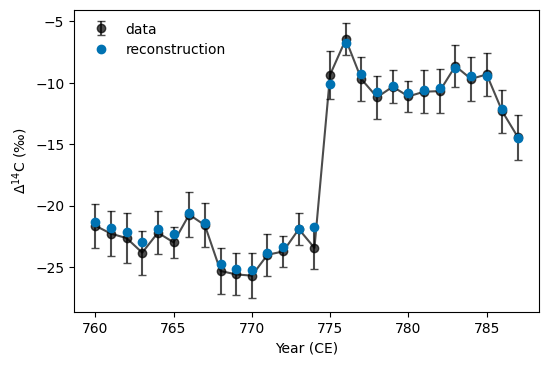

In [6]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
ax.errorbar(sf.time_data, sf.d14c_data, sf.d14c_data_error, fmt='o', 
            capsize=3, color="k", alpha=0.7, label="data")
ax.plot(sf.time_data, sf.d14c_data, color="k", alpha=0.7)
ax.errorbar(sf.time_data, d14c(mean), fmt='o', color=colors[0], label="reconstruction")
ax.legend(frameon=False)
ax.set_ylabel("$\Delta^{14}$C (‰)")
ax.set_xlabel("Year (CE)");